<a href="https://colab.research.google.com/github/SerhiiMis/deep_learning_goit/blob/main/dz_topic_06_SerhiiMishovych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Імпортуємо бібліотеки
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Монтуємо Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Копіюємо датасет у локальну пам’ять Colab (щоб пришвидшити завантаження)
!cp -r "/content/drive/MyDrive/datasets/intel/seg_train" "/content/"
!cp -r "/content/drive/MyDrive/datasets/intel/seg_test" "/content/"

In [5]:
# Вказуємо локальні шляхи
train_dir = "/content/seg_train"
test_dir = "/content/seg_test"

In [6]:
# Визначаємо трансформації для зображень
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Приводимо всі зображення до одного розміру
    transforms.ToTensor(),          # Перетворюємо в тензори
    transforms.Normalize((0.5,), (0.5,))  # Нормалізуємо дані
])

In [7]:
# Завантажуємо датасет через ImageFolder
train_data = ImageFolder(root=train_dir, transform=transform)
test_data = ImageFolder(root=test_dir, transform=transform)

In [8]:
# Розділяємо 20% тренувальних даних для валідації
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

In [9]:
# Створюємо DataLoader'и (з num_workers=2 для пришвидшення)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# Перевіряємо, чи доступний GPU
print("GPU доступний:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовуємо:", device)
print(torch.cuda.is_available())  # Має вивести True
print(torch.cuda.get_device_name(0))  # Має вивести "Tesla T4"

GPU доступний: True
Використовуємо: cuda
True
Tesla T4


In [10]:
# Перевіряємо кількість зображень у наборах
print(f"Тренувальних зображень: {len(train_data)}, Валідаційних: {len(val_data)}, Тестових: {len(test_data)}")

Тренувальних зображень: 11227, Валідаційних: 2807, Тестових: 3000


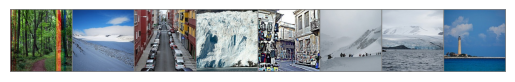

In [11]:
# Візуалізуємо кілька зображень із тренувального датасету
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

imshow(torchvision.utils.make_grid(images[:8]))

In [12]:
# Завантажуємо ResNet18 і модифікуємо для 6 класів
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 6)
resnet18 = resnet18.to(device)

print("ResNet18 готовий до навчання!")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


ResNet18 готовий до навчання!


In [13]:
# Визначаємо функцію втрат та оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [14]:
# Функція для оцінки моделі
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [15]:
# Функція для навчання моделі
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss={running_loss/len(train_loader):.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Навчання завершено за {total_time:.2f} секунд!")

In [20]:
# Запускаємо навчання
num_epochs = 10  # Можна збільшити для кращої точності
train_model(resnet18, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/10: Loss=0.1939, Train Acc=93.39%, Val Acc=87.42%
Epoch 2/10: Loss=0.1400, Train Acc=94.99%, Val Acc=87.46%
Epoch 3/10: Loss=0.1262, Train Acc=95.79%, Val Acc=86.36%
Epoch 4/10: Loss=0.1125, Train Acc=96.23%, Val Acc=88.78%
Epoch 5/10: Loss=0.0763, Train Acc=97.72%, Val Acc=86.18%
Epoch 6/10: Loss=0.1019, Train Acc=96.34%, Val Acc=86.53%
Epoch 7/10: Loss=0.0726, Train Acc=97.64%, Val Acc=88.46%
Epoch 8/10: Loss=0.0617, Train Acc=97.81%, Val Acc=89.17%
Epoch 9/10: Loss=0.0630, Train Acc=97.99%, Val Acc=89.24%
Epoch 10/10: Loss=0.0542, Train Acc=98.23%, Val Acc=88.31%
Навчання завершено за 255.84 секунд!


In [21]:
# Оцінка точності на тестовому наборі
test_acc = evaluate_model(resnet18, test_loader)
print(f"Точність на тестовому наборі: {test_acc:.2f}%")

Точність на тестовому наборі: 88.20%


In [23]:
# Збереження моделі
model_path = "/content/drive/MyDrive/resnet18_model.pth"
torch.save(resnet18.state_dict(), model_path)
print(f"Модель збережено в {model_path}!")

Модель збережено в /content/drive/MyDrive/resnet18_model.pth!


In [24]:
# Завантаження моделі (перевірка)
loaded_model = models.resnet18(weights=None)
loaded_model.fc = nn.Linear(num_ftrs, 6)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Модель успішно завантажена!")

Модель успішно завантажена!


<ipython-input-24-c98e99a42b84>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


Висновки за результатами класифікації зображень (Intel Image Classification)

1️⃣ **Використана модель**
У цьому проєкті використана Transfer Learning з ResNet18 для класифікації природних сцен із набору Intel Image Classification.
ResNet18 – це потужна згорткова нейронна мережа, яка вже навчена на великому наборі зображень (ImageNet), що дозволило швидко отримати хороші результати.

2️⃣ **Ключові результати**
📌 Після 10 епох навчання модель досягла таких метрик:
✅ Точність на тренувальному наборі: 98.23%
✅ Точність на валідаційному наборі: 88.31%
✅ Точність на тестовому наборі: 88.20%
✅ Час навчання: ~4 хвилини 15 секунд (Tesla T4 GPU)

Модель добре навчається і демонструє високу точність на тестових даних, що означає, що вона здатна класифікувати нові зображення з високою ефективністю.